In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import albumentations as A
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.patches import Rectangle


In [2]:
# get all train image names
# sample x% of the images
# apply stratified augmentation for both image and their corresponding bounding boxes
# save images and bounding boxes in yolo format
# update train.csv

In [3]:
DATA_PATH = 'data'
AUG_FRAC = 0.3
IMG_DIM = 448

In [4]:
affine_aug = A.Affine(translate_percent=0.2, p=1)
h_flip_aug = A.HorizontalFlip(p=1)
rand_bright_ctr_aug = A.RandomBrightnessContrast(p=1)
rotate_aug = A.Rotate(limit=30, p=1)
scale_aug = A.Affine(scale=(0.6, 0.8), p=1, keep_ratio=True)
# crop_aug = A.RandomCrop(p=1, width=300, height=300)

augmentors = [
    A.Compose([affine_aug, h_flip_aug], bbox_params=A.BboxParams(format='yolo')),
    A.Compose([h_flip_aug, rand_bright_ctr_aug], bbox_params=A.BboxParams(format='yolo')),
    A.Compose([rotate_aug, h_flip_aug], bbox_params=A.BboxParams(format='yolo')),
    A.Compose([scale_aug, affine_aug], bbox_params=A.BboxParams(format='yolo')),
    A.Compose([scale_aug, rotate_aug], bbox_params=A.BboxParams(format='yolo')),
]

In [5]:
def extract_files(path, aug_fraction):
    df = pd.read_csv(f"{path}/train.csv", header=None, names=["image", "label"])
    df = df.sample(frac=aug_fraction, random_state=123).reset_index(drop=True)

    images = []
    for file_name in df.image.values.tolist()[:7]:
        image_path = os.path.join(f"{path}/images/", file_name)
        image = Image.open(image_path)
        image_array = np.array(image)
        images.append(image_array)

    labels_raw = []
    for file_name in df.label.values.tolist()[:7]:
        label_path = os.path.join(f"{path}/labels/", file_name)
        with open(label_path, 'r') as file:
            lines = file.readlines()
            lines = [line.strip() for line in lines]
            labels_raw.append(lines)
        labels = [
            [
                [int(value) if i == 0 else float(value) for i, value in enumerate(item.split())]
                for item in nested_list
            ] 
            for nested_list in labels_raw
        ]

    return df, images, labels

In [6]:
train_df, train_images, train_labels = extract_files(DATA_PATH, AUG_FRAC)

In [7]:
def create_partitions(original_list):
    elements_per_sublist = len(original_list) // 5
    sublists = [original_list[i * elements_per_sublist: (i + 1) * elements_per_sublist] for i in range(5)]
    sublists[-1] += original_list[5 * elements_per_sublist:]
    return sublists

In [8]:
train_images_partitioned = create_partitions(train_images)
train_labels_partitioned = create_partitions(train_labels)

In [9]:
aug_images, aug_labels = [], []
train_labels_for_viz = []
for i, aug in enumerate(augmentors):
    for j, (image, bb) in enumerate(zip(train_images_partitioned[i], train_labels_partitioned[i])):
        bboxes = [box[1:] + [str(box[:1][0])] for box in bb]
        train_labels_for_viz.append(bboxes)
        transformed = aug(image=image, bboxes=bboxes)
        aug_images.append(transformed['image'])
        aug_labels.append(transformed['bboxes'])

In [10]:
def draw_boxes(ax, boxes, image_shape, color='r'):
    img_height, img_width, _ = image_shape
    for box in boxes:
        center_x, center_y, width, height, label = box
        x, y = (center_x - width / 2) * img_width, (center_y - height / 2) * img_height
        width, height = width * img_width, height * img_height
        rect = Rectangle((x, y), width, height, linewidth=1, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, f'{label}', color=color, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

def visualize_images(original_image, augmented_image, original_boxes, augmented_boxes):
    original_image_shape = original_image.shape
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original Image')
    draw_boxes(axs[0], original_boxes, original_image_shape)
    axs[1].imshow(cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))
    axs[1].set_title('Augmented Image')
    draw_boxes(axs[1], augmented_boxes, original_image_shape)
    plt.show()

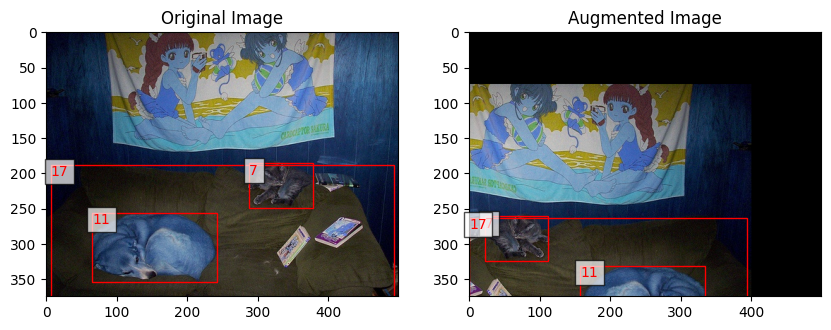

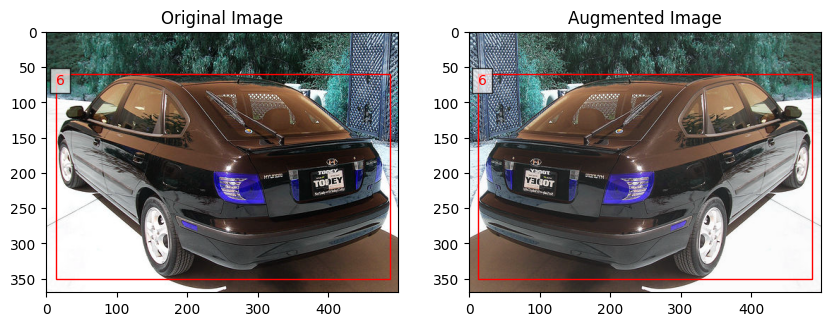

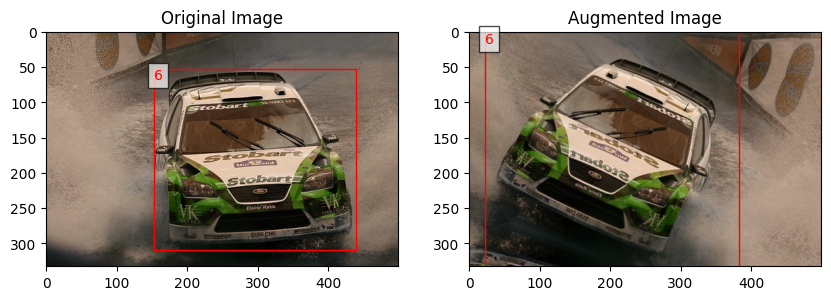

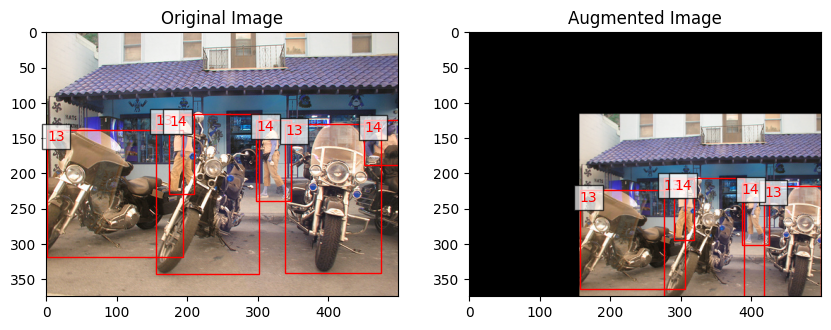

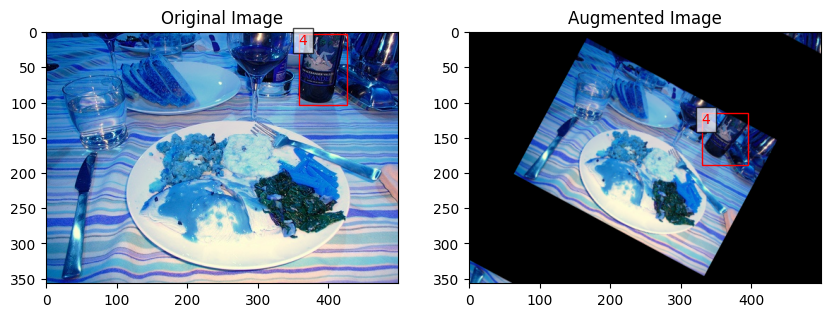

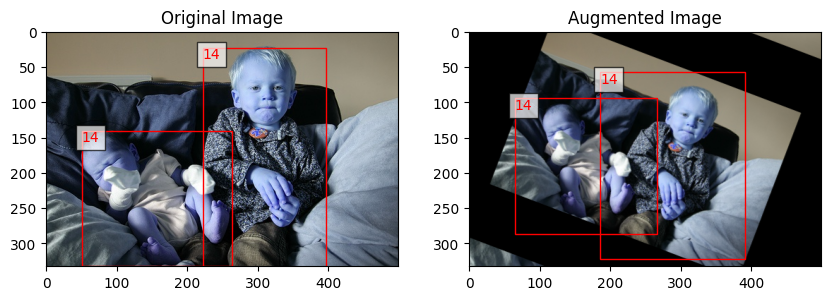

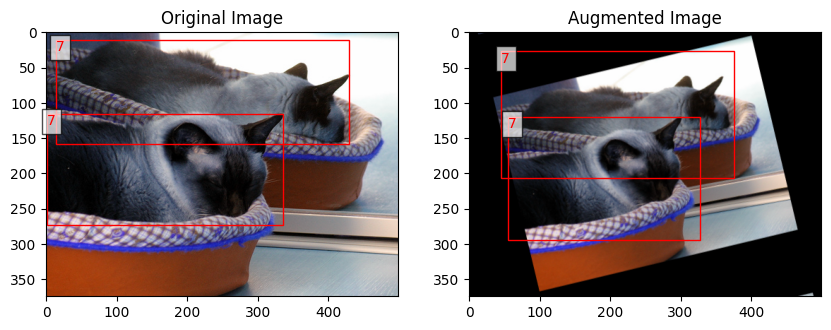

In [11]:
for i in range(len(aug_labels)):
    visualize_images(train_images[i], aug_images[i], train_labels_for_viz[i], aug_labels[i])